From notebook 1

In [3]:
from google.colab import files

# Upload the saved data.zip
uploaded = files.upload()

Saving data.zip to data.zip


In [4]:
!unzip data.zip -d data/

Archive:  data.zip
   creating: data/data/
  inflating: data/data/X_test.csv    
  inflating: data/data/preprocessor.pkl  
  inflating: data/data/german.csv    
  inflating: data/data/y_train.csv   
  inflating: data/data/X_train.csv   
  inflating: data/data/y_test.csv    


Loading the objects

In [6]:
import joblib
import pandas as pd

# Load from the correct folder
preprocessor = joblib.load("data/data/preprocessor.pkl")
X_train = pd.read_csv("data/data/X_train.csv")
X_test = pd.read_csv("data/data/X_test.csv")
y_train = pd.read_csv("data/data/y_train.csv").squeeze()
y_test = pd.read_csv("data/data/y_test.csv").squeeze()

print("✅ Loaded successfully:", X_train.shape, X_test.shape, y_train.shape, y_test.shape)

✅ Loaded successfully: (800, 23) (200, 23) (800,) (200,)


XGBoost + Calibration + SHAP

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [05:17:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost ROC-AUC (uncalibrated): 0.8025000000000001


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [05:17:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [05:17:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [05:17:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [05:17:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [05:17:39] WARNING: /w

XGBoost ROC-AUC (calibrated): 0.8173809523809524


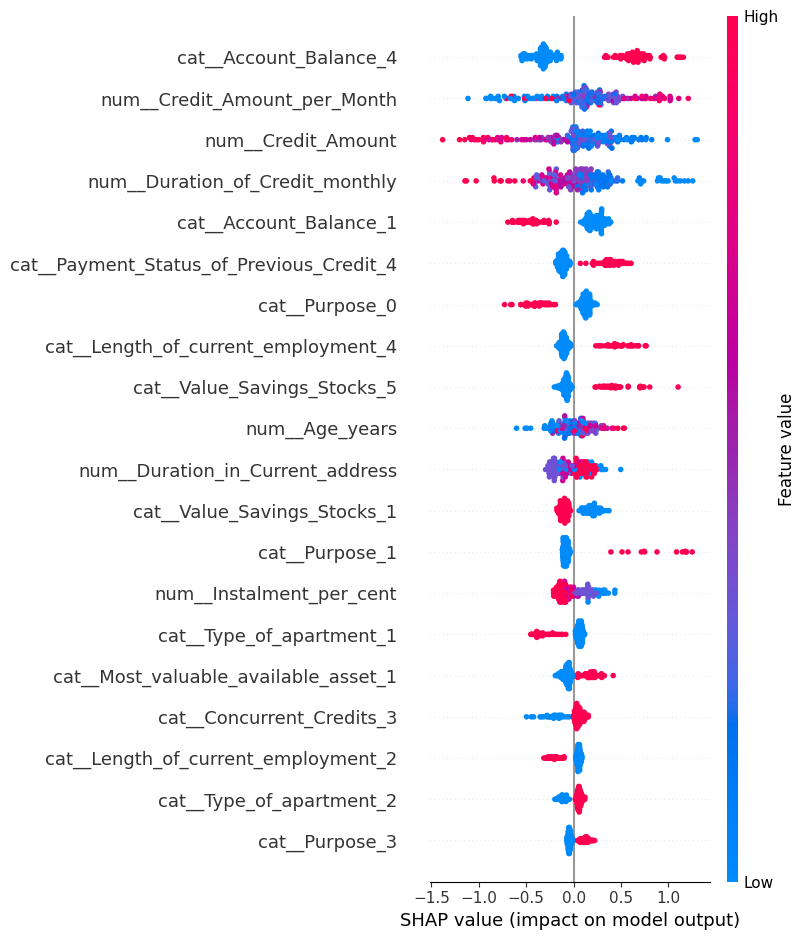

<Figure size 640x480 with 0 Axes>

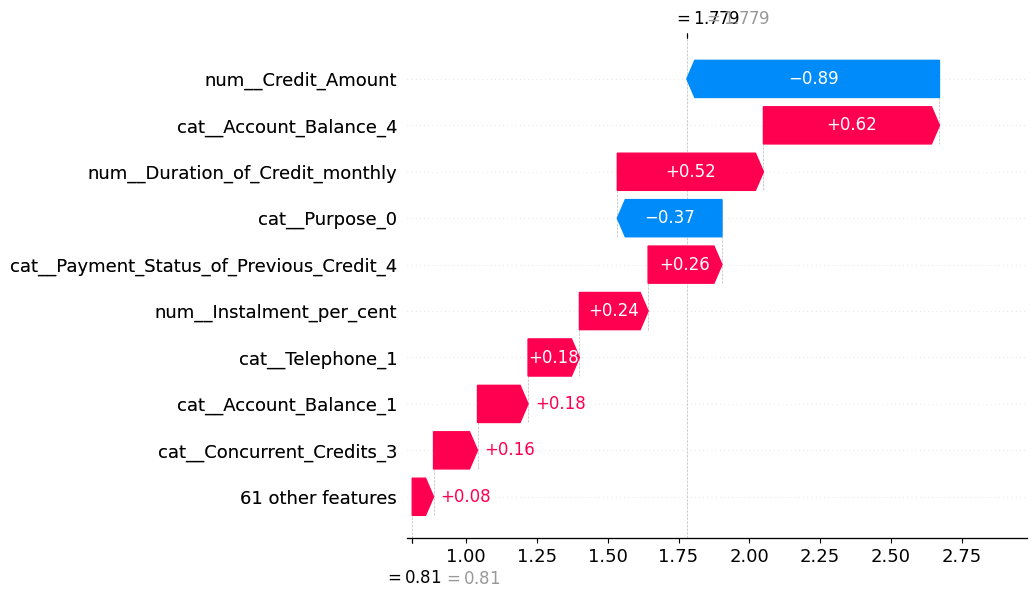

Saved SHAP summary as PNG + local explanation as PNG and HTML.


In [7]:
# -------------------------------
# Step 7: XGBoost + Calibration + SHAP
# -------------------------------

from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score
import shap
import matplotlib.pyplot as plt

# 1. Preprocess features
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)

# 2. Train base XGBoost model
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss"
)

xgb.fit(X_train_proc, y_train)

# 3. Raw predictions
y_proba_xgb = xgb.predict_proba(X_test_proc)[:,1]
print("XGBoost ROC-AUC (uncalibrated):", roc_auc_score(y_test, y_proba_xgb))

# 4. Calibrate probabilities
calibrator = CalibratedClassifierCV(xgb, method='isotonic', cv=5)
calibrator.fit(X_train_proc, y_train)
y_proba_cal = calibrator.predict_proba(X_test_proc)[:,1]
print("XGBoost ROC-AUC (calibrated):", roc_auc_score(y_test, y_proba_cal))

# 5. SHAP explainability
# Correct setup for tree models
explainer = shap.TreeExplainer(xgb, feature_perturbation="tree_path_dependent")

# SHAP values (may return list for binary classification)
shap_values = explainer.shap_values(X_test_proc)
if isinstance(shap_values, list):
    shap_values = shap_values[1]  # positive class (default = 1)

# Feature names
try:
    feature_names = preprocessor.get_feature_names_out()
except:
    feature_names = [f"f{i}" for i in range(X_test_proc.shape[1])]

# --- Global importance plot ---
shap.summary_plot(shap_values, X_test_proc, feature_names=feature_names)

# Add a proper title without creating an empty figure
plt.gcf().suptitle("SHAP Summary Plot", fontsize=14)
plt.subplots_adjust(top=0.9)  # prevent title overlap

plt.savefig("shap_summary.png", bbox_inches="tight")
plt.show()

# --- Local explanation for 1 observation ---
i = 5
force_plot = shap.force_plot(
    explainer.expected_value,
    shap_values[i, :],
    X_test_proc[i, :],
    feature_names=feature_names
)

# Save as interactive HTML
shap.save_html("shap_local.html", force_plot)

# Also save local explanation as static PNG using waterfall plot
plt.figure()
shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value,
    shap_values[i, :],
    feature_names=feature_names
)
plt.title(f"Local Explanation for Sample {i}")
plt.savefig("shap_local.png", bbox_inches="tight")
plt.close()

print("Saved SHAP summary as PNG + local explanation as PNG and HTML.")

In [10]:
from sklearn.linear_model import LogisticRegression

# Re-train logistic regression on the processed data
X_train_proc = preprocessor.transform(X_train)
X_test_proc = preprocessor.transform(X_test)

logreg = LogisticRegression(max_iter=1000, solver='liblinear')
logreg.fit(X_train_proc, y_train)

# Logistic Regression probabilities
y_proba_log = logreg.predict_proba(X_test_proc)[:,1]

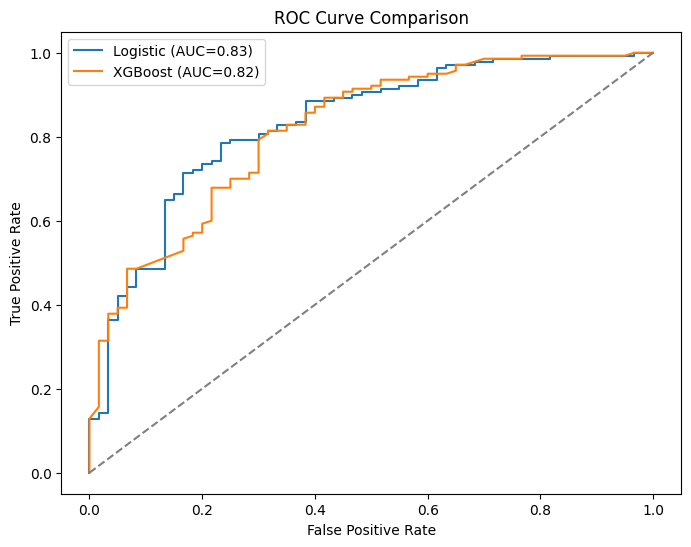

In [12]:
# -------------------------------
# Step 7.5: Compare Logistic vs XGBoost
# -------------------------------

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Preprocess train/test again
X_train_proc = preprocessor.transform(X_train)
X_test_proc = preprocessor.transform(X_test)

# Re-train Logistic Regression
logreg = LogisticRegression(max_iter=1000, solver='liblinear')
logreg.fit(X_train_proc, y_train)

# Probabilities
y_proba_log = logreg.predict_proba(X_test_proc)[:,1]
y_proba_xgb = y_proba_cal   # from calibrated XGBoost

# ROC curves
fpr_log, tpr_log, _ = roc_curve(y_test, y_proba_log)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)

plt.figure(figsize=(8,6))
plt.plot(fpr_log, tpr_log, label=f"Logistic (AUC={roc_auc_score(y_test,y_proba_log):.2f})")
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC={roc_auc_score(y_test,y_proba_xgb):.2f})")
plt.plot([0,1],[0,1],'--', color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()